In [10]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///db/stock_data.db")
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-5-mini")
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
from langgraph.prebuilt import create_react_agent
system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)
stock_agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
    name="stock_agent",
)

In [11]:
def mortgage_payment_calculator(loan_amount: float, annual_interest_rate: float, number_of_payments:int):
    """Calculate the monthly payment of a mortgage"""
    monthly_interest_rate=annual_interest_rate/12
    monthly_payment=loan_amount*monthly_interest_rate*(1 + monthly_interest_rate)**number_of_payments/\
                    ((1.0 + monthly_interest_rate)**number_of_payments - 1.0)
    return monthly_payment
    
mortgage_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[mortgage_payment_calculator],
    prompt=(
        "You are a mortgage agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with mortgage payment calculation\n"
        "- Ask for loan amount, annual interest rate, or number of payments, if any of them not provided\n"
        "- Combine already provided function parameters in history to complete the calculation\n" 
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="mortgage_agent",
)

In [12]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-5-mini"),
    agents=[stock_agent, mortgage_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a stock agent. Assign stock price query tasks to this agent\n"
        "- a mortgage agent. Assign mortgage monthly payment tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
    name="supervisor_agent",
).compile()

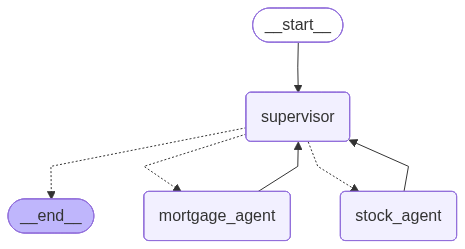

In [13]:
from IPython.display import display, Image
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [16]:
import gradio as gr
async def chat_with_agent(message, history):
    # LangGraph agents expect messages in a specific format
    #print(history)
    messages = history + [{"role": "user", "content": message}]    
    # Invoke the agent
    response = await supervisor.ainvoke({"messages": messages})
    
    # Extract the agent's reply
    agent_reply = response["messages"][-1].content
    return agent_reply

# 5. Create the Gradio interface
iface = gr.ChatInterface(
    fn=chat_with_agent,
    type="messages"
)

# 6. Launch the Gradio app
if __name__ == "__main__":
    iface.launch()

* Running on local URL:  http://127.0.0.1:7880
* To create a public link, set `share=True` in `launch()`.


In [5]:
!pip install langgraph_supervisor

  Using cached langgraph_supervisor-0.0.29-py3-none-any.whl.metadata (13 kB)
Using cached langgraph_supervisor-0.0.29-py3-none-any.whl (16 kB)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
